# Finding emerging behaviors in a time series

This notebook reproduces [Matrix Profile XXV: Novelets](https://static1.squarespace.com/static/56dca322f8baf30cf9752a85/t/631900e16f7b7e792701943a/1662583010347/Novelets_V029_CameraReady.pdf). 

This paper proposes an algorithm that can discover emerging behavior, named as **Novelets**, in a time series.

## import libraries

In [8]:
%matplotlib inline

import pandas as pd
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy.io import loadmat

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Toy data

In [20]:
data = loadmat('Novelets_datasets/data01_Toy.mat')
T = np.squeeze(data['pos'])

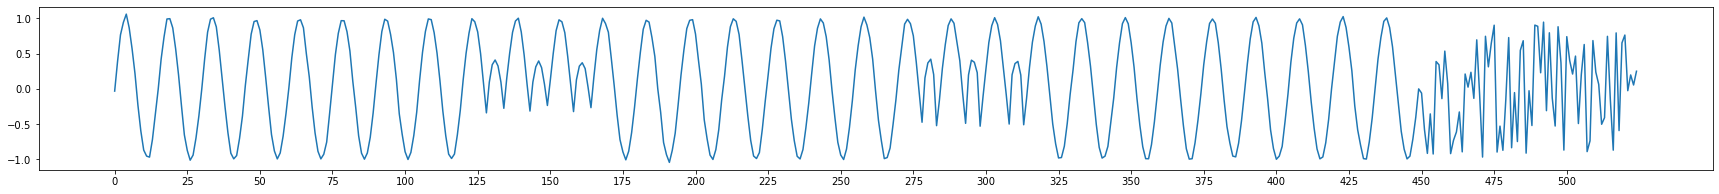

In [21]:
tags = np.arange(0, len(T_ref), 25)

# visualize data
plt.figure(figsize=(30, 3))
plt.plot(T)
plt.xticks(ticks=tags, labels=tags)
plt.show()

Here, we can see that there is a new pattern that is starting around index `125`, and this emerging behavior is repeated in index `275`. We call the first new subsequence the Novelet.

---

There are few things need to be clarified though (For further detials, check out the [paper](https://static1.squarespace.com/static/56dca322f8baf30cf9752a85/t/631900e16f7b7e792701943a/1662583010347/Novelets_V029_CameraReady.pdf)).

**1) Why not motif?** 
While novelets may be time series motifs, most motifs are not Novelets. For example, `Beat` in `BeatzBeatyBeatx` is a strong motif. In the incoming stream, we may have something like this: `BeatwBeatvBeatsPadaqBeatrPatajBeat`. If we look at it closely, we can see there is `Pada`/`Pata` pair. Hence, this may be overlooked by motif discovery.

**2) Why not anomlay?**
An anomaly is typically a shape that occurs once, whereas a Novelet is the first instance of a repeated shape.

**3) Why not chain?**
There are two difference here. For one, a chain must be of at least length three, whereas a Novelet may be detected with just two occurences. For another, w can think of `chain` as a slowly changing behavior; however, novelet is a completely novel behavior.

**4) Why not segementation/change detection?**
In a trivial case where there are two regimes, the outputs of segmentations and novelets may both point out to the start of each regime. However, in practice, segmentation usually works well when the data is highly periodic. However, Novelets only need to see two examples of a new behavior.


**5) Why not clustering?**
They have different purposes. For instance, a novelet can detect when new ryhme schemes begin in a song lyric. However, a clustering process results in grouping all words belonging to a scheme.


**Personal Opinion:** Why not the anomaly twin-freak ???
For instance, one may use [DAMP](https://www.cs.ucr.edu/~eamonn/DAMP_long_version.pdf) to discover anomaly, and if it repeated again, we can call it emerging behavior.

## Novelet
 a Novelet is the **first** instance- of new behavior- of a repeated shape. Note that we cannot say a subsequnce shows an emerging behavior in its first appearence. Because, that might be just a unique event (or anomaly). If this behavior is repeated again, then we can call it an emerging behavior. 
 
Therefore, if the novelet subsequence `S` appears later as `S'`, then we call `S` novelet. Therefore, to detect novelet, our aim is to find `S'`, a subsequence that has a close left nearest neigbor but is far from the regular patterns in the data. 

We now demonstrate how this concept works. First, let us plot `T`, `T_ref`. The former is the time series from which a Novelet is going to be discovered. The latter, i.e, `T_ref`, is a time series containing the patterns that cannot be considered as emerging behavior. For instance, in the previous figure, the sinusidal curve can be considered as the background data. Hence, we would like to avoid choosing a pattern as an emerging behavior if it is similar to sinusidal curve.

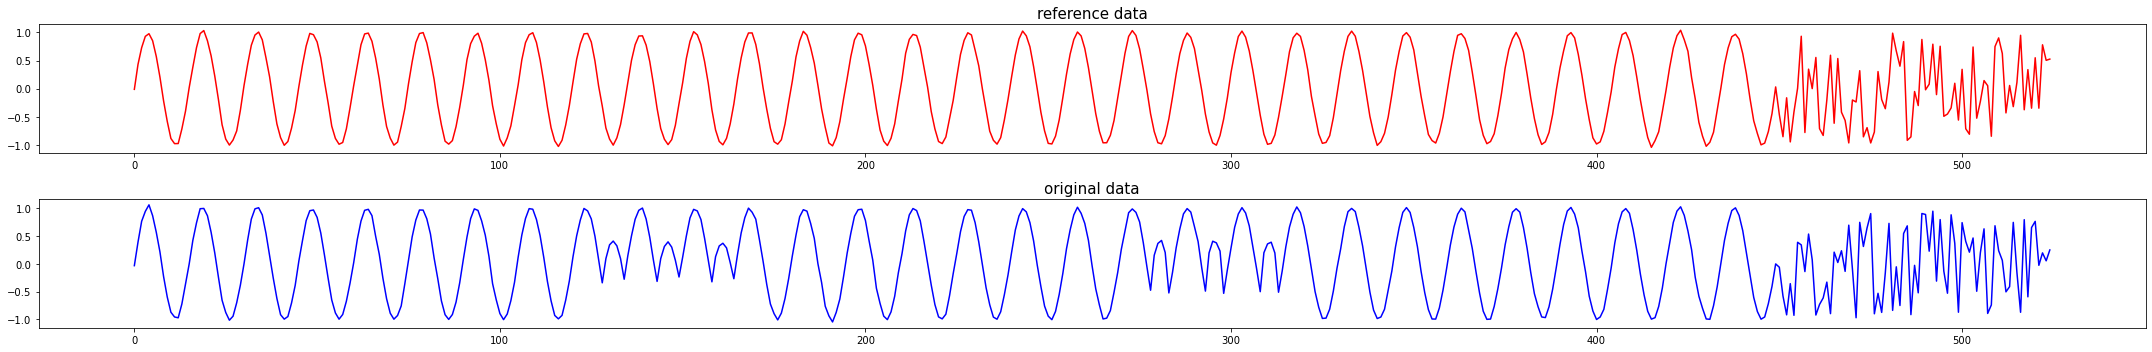

In [35]:
T_ref = np.squeeze(data['neg'])

fig, axs = plt.subplots(2, 1, figsize=(30, 5))
axs[0].plot(T_ref, color='r')
axs[0].set_title('reference data', fontsize=15)

axs[1].plot(T, color='b')
axs[1].set_title('original data', fontsize=15)
plt.tight_layout()
plt.show()

To find the emerging behavior, we first calculate emerging profile, `ep`, as follow:

In [55]:
T_A = T.copy()
T_B = T_ref.copy()

m = 50
max_d = np.sqrt(2 * m) # maximum distance with non-negative correlation

mp_AB = stumpy.stump(T_A, m, T_B, ignore_trivial=False)
P_AB = mp_AB[:, 0].astype(np.float64)

mp_AA = stumpy.stump(T_A, m)
IL = mp_AA[:, 2].astype(np.int64) # left matrix profile indices
P_AA_left = stumpy.core._idx_to_mp(IL, T_A, m)


ep = P_AB - P_AA_left

# why clipping?
ep[:] = np.clip(ep, a_min=0.0, a_max=max_d) # converting neg to 0.
ep[:] = ep / max_d

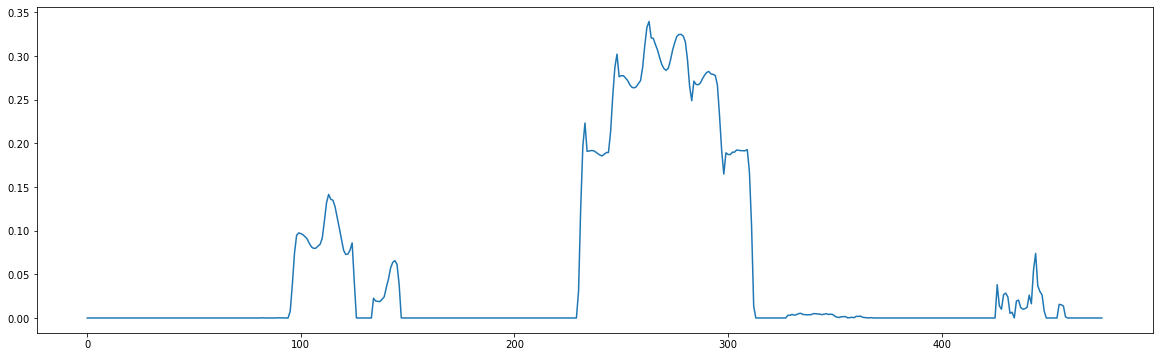

In [53]:
plt.plot(ep, label='Emergence Profile')
plt.show()

Note that a high value at index `idx` in the "Emergence Profile", `ep`, means that the subsequence at such index has large distance to its NN in the reference time series, but it has a small distance to its left nearest neighbor. In other words, this is a new behavior that was not close to the patterns in reference, but it occured once before in the time series `T`.

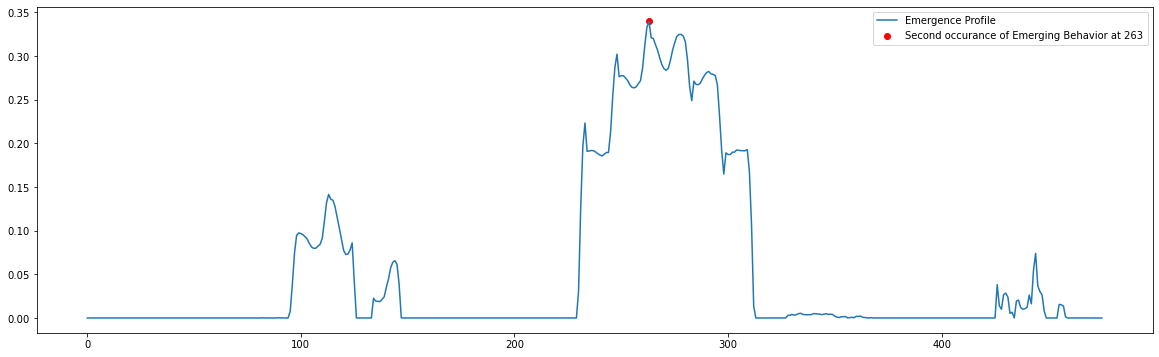

In [56]:
idx = np.argmax(ep)

plt.plot(ep, label='Emergence Profile')
plt.scatter(idx, ep[idx], color='r', marker='o', label=f'Second occurance of Emerging Behavior at {idx}')
plt.legend()
plt.show()

Now, we can use the left matrix profile `IL`, to find the first occurance of this behavior:

In [57]:
idx_novelet = IL[idx]
print(f'the Novelet start at index {idx_novelet}')

the Novelet start at index 113


**Personal Opinion:** Why not using `IR`? We can find the lowest index `i`, where `IR[i]` is `idx`. Because, we start with this concept that we would like to find the **second** occurance of a new behavior. Hence, in my opinion, this should be NN to the first occurance. Therefore, the right nearest neighbor of the first occurance should be the discovered behavior.

Let's plot the novelet and its second occurence:

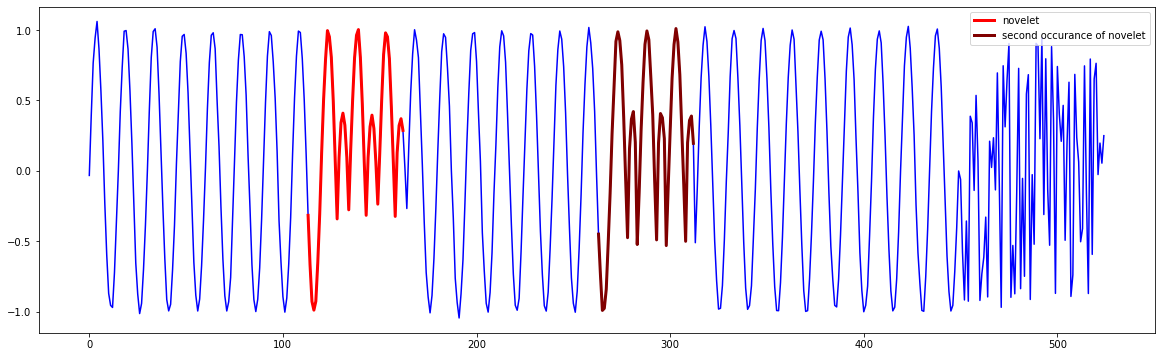

In [58]:
plt.plot(T, color='b')
plt.plot(np.arange(idx_novelet, idx_novelet + m), T[idx_novelet:idx_novelet+m], color='r', linewidth=3, label='novelet')
plt.plot(np.arange(idx, idx + m), T[idx:idx+m], color='maroon', linewidth=3, label='second occurance of novelet')
plt.legend()
plt.show()

## Novelet algorithm

In [ ]:
class novelet:
    def __init__(self, T_A, m, d, T_B=None):
        self._T_A = T_A
        self._T_B = T_B
        self._m = m
        self._d = d
        
        mp_AA = stumpy.stump(self._T_A, self._m)
        IL = mp[:, 2].astype(np.int64)
        self._PL_AA = stumpy.core._idx_to_mp(IL, T, m)
        
        if self._T_B is not None:
            mp_AB = stumpy.stump(self._T_A, m, self._T_B, ignore_trivial=False)
            self._P_AB = mp_AB[:, 0].astype(np.float64)
        else:
            n = len(self._T_A) - self._m + 1
            self._P_AB = np.full(n, np.sqrt(2 * self._m), dtype=np.float64)
        
        self._EP = self._P_AB - self._PL_AA
        self._EP[:] = np.clip(self._EP, 0.0, np.sqrt(2 * m))
        self._EP[:] = self._EP / np.sqrt(2 * m)
        
        self._novelet = []
        
    def update(self, t)
        self._T_A = np.append(self._T_A, t)
        last_seq = self._T_A[-m:]
        stumpy.core.mass(last_seq, self._T_B):
        return
    
    
    @property
    def novelet_index(self):
        idx = np.argmax(self._EP)
        if self._EP[idx] >= d:
            self.novelet_idx = self._IL[idx]
        else:
            self.novelet_idx = -1
        
        return self.novelet_idx